For a complete description of the data set please visit the Kaggale page
https://www.kaggle.com/c/titanic/data

### Author: Ahsan Khan

## This notebook demonstrates a worked out example of the Naive Bayes analysis and the usage of scikitlearn naive bayes method. Attempts have been made to provide an intuitive understanding of the naive bayes model
#### Also hopefully it will serve as a note for myself to use in the future in case I forget all these.
#### For a complete explanation of Naive Bayes theorem and conditional probability please consult a text book. The following book has an excellent chapter on Naive Bayes model (Chap 6, Edition:1) "Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies by John D. Kelleher, Brian Mac Namee, Aoife D'Arcy" 

#### The following conditional probablility noation is adopted in this notebook 
#### $P(A|B) = P(A\ GIVEN\ B)$ =  probability of event A given event B has occured

#### To calculate the likelihood of a feature Y to have a value of Y_v given 
that feature $X_1, X_2, X_3.....X_n$ assume partcular values $X_1v, X_2v, X_3v...X_nv$ the following formula is used:

  $P(Y = Y_v\  |\  X_1=X_1v, X_2=X_2v, X_3=X_3v, ...X_n=X_nv) = 
  P(Y) \  P(X_1=X_1v | Y=Y_v ) \  P(X_2=X_2v | Y=Y_v ) \ P(X_3=X_3v | Y=Y_v ) \  .... \  P(X_n=X_nv | Y=Y_v ) $ <br>
 
#### Where, P(Y) = Overall probability of feature Y <br>
 $P(X_1=X_1v\ |\ Y=Y_v)=$ conditional probability of feature $X_1$ having a value of $X_1v$ when feature Y assumes the value $Y_v$ <br>        
 $P(X_n=X_nv\ |\ Y=Y_v)=$ conditional probability of feature $X_n$ having a value of $X_nv$ when feature $Y$ assumes the value $Y_v$  <br>
 
#### The above formula can only be derived under that assumption that there is no dependency between any two of the features $X_1, X_2, X_3.....X_n$ <br>

#### Well this assumption is responsible for the qualifier "NAIVE" in the name "Naive Bayes"

## Even though the formula and all these may look confusing at this moment, it's application will be easily uderstood once we start calculating probabilities. So don't worry at this moment much. Lets start with the Titatnic data series.

In [171]:
%reset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import the data files
url = "https://rawgit.com/ahsan2github/titanic/master/train.csv"
train = pd.read_csv(url);
# ok now that the data set is loaded, lets take a peek at the dataset
#train_set = pd.get_dummies(train, columns=['Sex']);
print("\n"); print(train.sample(3).to_string()); print("\n");



     PassengerId  Survived  Pclass                             Name     Sex  Age  SibSp  Parch    Ticket     Fare Cabin Embarked
770          771         0       3           Lievens, Mr. Rene Aime    male   24      0      0    345781   9.5000   NaN        S
376          377         1       3  Landergren, Miss. Aurora Adelia  female   22      0      0    C 7077   7.2500   NaN        S
30            31         0       1         Uruchurtu, Don. Manuel E    male   40      0      0  PC 17601  27.7208   NaN        C




#### Ok so there are 11 features found for each passenger identified by passengerID. These 11 features are 
#### (1)Survived, (2)Pclass, (3)Name, (4)Sex, (5)Age, (6)SibSp, (7)Parch, (8)Ticket, (9)Fare, (10)Cabin, (11)Embarked  
#### Out of these 11 features we have one TARGET feature and that is the "Survived" feature. In this data set We are interested to make a prediction for each passenger whether they had survived or not based on the categorical / numerical values of the 10 other features that characterize every passernger. At this point a closer inspection of the features may reveal that some of the some features in fact do not provide much useful information. For example "Ticket" feature which simply provides the ticket number must not have any impact on the survival of the passenger. Also, "Pclass", "Fare" and "Cabin" feature in a way convey similar information. However, for this simple analysis all possible features will not be considered. Here, for the sake of simplicity predictions will be made using only THREE features i.e. "Sex", "Pclass", and "Age". To understand the importance of these features in connection to survival we can make factor plots:

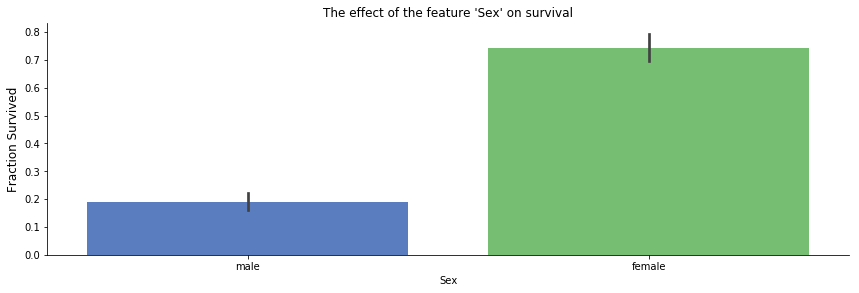

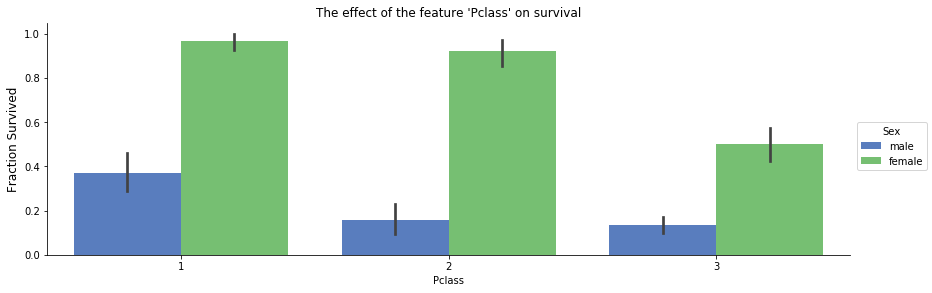

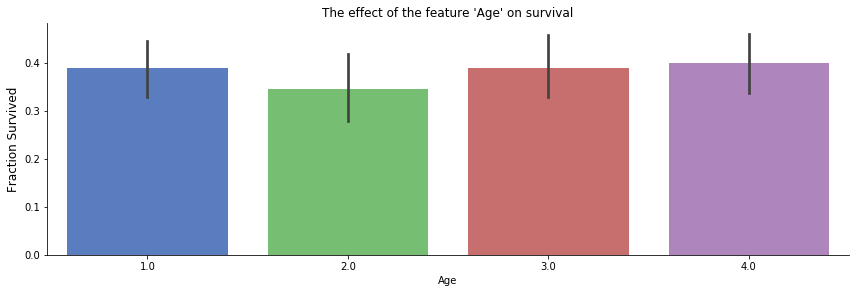

In [172]:
fig = sns.factorplot(x="Sex", y="Survived", data=train,
                   size=4, aspect=3, kind="bar", palette="muted")
plt.title("The effect of the feature 'Sex' on survival")
plt.ylabel("Fraction Survived", FontSize=12)
plt.show()


ax = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                    size=4, aspect=3, kind="bar", palette="muted")
plt.title("The effect of the feature 'Pclass' on survival")
plt.ylabel("Fraction Survived", FontSize=12)
plt.show()

# check which rows contain NaN in Age column
boolColVec = train['Age'].isnull()
# now replace NaN values in 'Age' column with 0
train.loc[boolColVec, 'Age'] = np.double(0) 

# divide age into 4 categories
def age_class(x):
    if np.double(x)>= 0 and np.double(x) < 18:
        x = 1.0;
    elif np.double(x) >=18 and np.double(x)< 25:
        x = 2.0;
    elif np.double(x) >=25 and np.double(x) < 35:
        x = 3.0;
    else:
        x = 4.0;
    return x;
train.Age = train['Age'].apply(age_class)
fig = sns.factorplot(x="Age", y="Survived",data=train,
                    size=4,aspect=3, kind="bar", palette="muted")
plt.title("The effect of the feature 'Age' on survival")
plt.ylabel("Fraction Survived", FontSize=12)
plt.show()

#### From the plots it is apparent that Sex is a very important deciding factor on Survival. The second most important feature is the Pclass. The Age feature is slightly different in its representation from the other two. The Age feture is characterized by a continuous fucntion. To make the Age feature usable in modeling with Multinomial distribution we have remapped continuous values into four distinct categories 1, 2, 3, 4. The actual mapping has been done using the age_class function. The function is simple and self explanatory. 

#### At this point we are interested to know the degree of two possibilities for each passenger GIVEN she/he is characyerized by the three features 'Sex', ''Pclass', and categorical 'Age'. Remember the target feature Survived assumes two values 0 (did not survive) and 1 (survived). Lets consider the passenger with passengerId=1. 

In [173]:
# lets also drop the features we will not be using / keep only the features we will be using and see what the records look like
dummy = train[['PassengerId','Pclass', 'Sex', 'Age']];
print("\n"); print(dummy.head(2).to_string()); print("\n");



   PassengerId  Pclass     Sex  Age
0            1       3    male    2
1            2       1  female    4




#### We want to calculate the likelihood of survival or death for passengerId = 1. In terms of Naive Bayes model we want to calculate the two probabilities
$P(Survived=1\ |\ PassengerId=1)\ = \ P(Survived = 1\ |\ Pclass=3,\ Sex=male,\ Age=2) \text{, And}$ 

$P(Survived=0\ |\ PassengerId=1)\ = \ P(Survived = 0\ |\ Pclass=3,\ Sex=male,\ Age=2)$ 

#### Infact to predict the fate of each passenger these two probabilities will be calculated for each passenger e.g. for PassengerId = 2 the following needs to be calculated

$P(Survived=1\ |\ PassengerId=2)\ = \ P(Survived = 1\ |\ Pclass=1,\ Sex=female,\ Age=4) \text{, And}$ 

$P(Survived=0\ |\ PassengerId=2)\ = \ P(Survived = 0\ |\ Pclass=1,\ Sex=female,\ Age=4)$ 

#### At this point we need use the Naive Bayes formula. Say, for PassengerID = 2 we get to calculate the above two probabilities using the following Naive Bayes formula

$P(Survived = 1\ GIVEN\ Pclass=1,\ Sex=female,\ Age=4) = P(Survived=1)\ P(Pclass=1\ | \ Survived = 1)\ P(Sex=Female\ |\ Survived=1)\ P(Age=4\ |\ Survived=1) \text{, And}$ 

$P(Survived = 0\ GIVEN\ Pclass=1,\ Sex=female,\ Age=4) = P(Survived=0)\ P(Pclass=1\ | \ Survived = 0)\ P(Sex=Female\ |\ Survived=0)\ P(Age=4\ |\ Survived=0)$

#### Lets first calculate the probabilities P(Survived=1) and P(Survived=0)

In [174]:
# pivot against 'Survived' feature, get a new data frame and get percent survived  
# To make the calculation easier we introduce a new column(feature) labeled  Unit which will have a value of 1 for each record (Passenger)
# When we use this 'Unit' feature with numpy sum() function we can easily see in the pivot table the total number of passengers belonging to 
# the categories Survived=0 and Survived=1
train['Unit'] = 1
# lets see what the dataset looks like after the introduction of the Unit column
print("\n"); print(train.sample(2).to_string()); print("\n");
print("=====================================================================================================================================================================")
pivot_survived  = pd.pivot_table(train,index=["Survived"], values=[ "Unit"],aggfunc=np.sum)
pivot_survived.reset_index(level=0, inplace=True) 
print("Total number of passengers belonging to each category under Survived features are shown in Unit column"); print("\n\n");
print(pivot_survived.to_string())



     PassengerId  Survived  Pclass              Name   Sex  Age  SibSp  Parch              Ticket     Fare Cabin Embarked  Unit
363          364         0       3   Asim, Mr. Adola  male    4      0      0  SOTON/O.Q. 3101310   7.0500   NaN        S     1
622          623         1       3  Nakid, Mr. Sahid  male    2      1      1                2653  15.7417   NaN        C     1


Total number of passengers belonging to each category under Survived features are shown in Unit column



   Survived  Unit
0         0   549
1         1   342


#### Now the probabilities $P(Survived = 1)$, and $P(Survived=0)$ can be calculated easily

$P(Survived =1) = \frac{342}{342+549} = 0.3838$ <br>
$P(Survived =0) = \frac{549}{342+549} = 0.6162$
#### However, the probabilities for the modeling purpose will be calculated using a slightly different formula assuming $\alpha=1$
$P(Survived =1) = \frac{342+\alpha}{342+549+\alpha \times 2} = 0.3841$ <br>
$P(Survived =0) = \frac{549+\alpha}{342+549+\alpha \times 2} = 0.6159$

### Whats the deal with $\alpha$?

#### $\alpha$  is called the Laplace smoothing parameter. Iy prevents from overfitting. It transfers some of the probability from highly likely category to less likely category (like Robinhood!). See without the $\alpha$ parameter the $P(Survived =1)$ was $0.3838$ and after introducing it $P(Survived =1)$ increased to $0.3841$ while, $P(Survived =0)$ decreased to $0.6159$ from $0.6162$. Lets consider a more extreme case. Suppose from training data set we see the following that out of 891 passengers no one survived and we still want to predict the survival of passengers in a test data set. In this case the training data set clearly shows no chance of survival for anyone!. 
Survived | Unit|            
---------| ---:  
 0       | $891$ 
 1       | $0$  

#### However, with the introduction of $\alpha$ the zero probability can be avoided. So $\alpha$ works as a smoothing parameter.  
$P(Survived =1) = \frac{0 + \alpha}{891 + \alpha \times 2} = 0.0011$ <br>
$P(Survived =0) = \frac{891+\alpha}{891+\alpha \times 2} = 0.9989$ 

### Simple rule in using the $\alpha$ parameter:
+ Assume a value of $\alpha$, typically between $1$ to $3$. Here for all calculations $\alpha =1$ is assumed
+ Add $\alpha$ to the numerator 
+ Multiply $\alpha$ with the total number of categories in the freature before adding to the Denominator. Here, the feature 'Survived' can take only two values, $0$ and $1$. So, when alpha is added to the denominator it is multiplied by $2$.
#### For more information about smoothing please refer to a book.
#### Ok, lets go back to calculating probabilties. We saw that to know the fate of the Passenger with PassengerId=2  we need to calculate the probabilities
$P(Pclass=1\ | \ Survived = 1), \ P(Sex=Female\ |\ Survived=1), \ P(Age=4\ |\ Survived=1)$ 
$P(Pclass=1\ | \ Survived = 0), \ P(Sex=Female\ |\ Survived=0), \ P(Age=4\ |\ Survived=0)$
#### Before proceeding further, we make a small transformation to the data, we map the categorical values 'male', 'female' values of the Sex feature to $0$ and $1$. When we will use the scikitlearn's MultonomialNB function we will have to have numerical values for all features

In [175]:
train.Sex = train['Sex'].map({'female':0,'male':1}).astype(int)

### Calculation of Probabilities for the Sex feature

In [176]:
# pivot against 'Sex' feature, get a new data frame and get percent survived  
pivot_sex  = pd.pivot_table(train,index=["Survived", "Sex"], values=[ "Unit"],aggfunc=np.sum)
pivot_sex.reset_index(level=0, inplace=True) 
print("\n"); print(pivot_sex.to_string()); print("\n");



     Survived  Unit
Sex                
0           0    81
1           0   468
0           1   233
1           1   109




#### (1) $P( sex = 0\ |\ survived = 1 ) = \frac{ 233 + \alpha }{ 233 + 109 + \alpha \times 2 } = 0.6802 $
#### (2) $p( sex = 1\ |\ survived = 1 ) = \frac{ 109 + \alpha }{ 233 + 109 + \alpha \times 2 } = 0.3198$ 
#### (3) $P( sex = 0\ |\ survived = 0 ) = \frac{81 + \alpha}{ 81 + 468 + \alpha \times 2 } = 0.1488$ 
#### (4) $P( sex = 1\ |\ survived = 0 ) = \frac{ 468 + \alpha }{ 81 + 468 + \alpha \times 2} = 0.8512$ 

### Calculation of Probabilities for the Pclass feature

In [177]:
pivot_pclass = pd.pivot_table(train,index=["Survived", "Pclass"], values=[ "Unit"],aggfunc=np.sum)
pivot_pclass.reset_index(level=0, inplace=True) 
print("\n"); print(pivot_pclass.to_string()); print("\n");



        Survived  Unit
Pclass                
1              0    80
2              0    97
3              0   372
1              1   136
2              1    87
3              1   119




#### (5)  $P( Pclass = 1\ |\  survived = 1 ) = \frac{136+\alpha}{ 136 + 87 + 119+\alpha \times 3} = 0.397$
#### (6)  $P( Pclass = 2\ |\  survived = 1 ) = \frac{87 + \alpha}{ 136 + 87 + 119 + \alpha \times 3} = 0.2551$
#### (7)  $P( Pclass = 3\ |\ survived = 1 ) = \frac{119 + \alpha}{136 + 87 + 119 + \alpha \times 3} = 0.3478$
#### (8)  $P( Pclass = 1\ |\ survived = 0 ) = \frac{80 + \alpha}{ 80 + 97 + 372 + \alpha \times 3} = 0.147$
#### (9)  $P( Pclass = 2\ |\ survived = 0 ) = \frac{97 + \alpha}{ 80 + 97 + 372 + \alpha \times 3} = 0.1779$
#### (10) $P( Pclass = 3\ |\ survived = 0 ) = \frac{372 + \alpha}{ 80 + 97 + 372 + \alpha \times 3} = 0.6770$

### Calculation of probabilities for the Age feature

In [178]:
pivot_Age = pd.pivot_table(train,index=["Survived", "Age"], values=[ "Unit"],aggfunc=np.sum)
pivot_Age.reset_index(level=0, inplace=True) 
print("\n"); print(pivot_Age.to_string()); print("\n"); 



     Survived  Unit
Age                
1           0   177
2           0   108
3           0   123
4           0   141
1           1   113
2           1    57
3           1    78
4           1    94




#### (11) $P ( Age = 1\ |\ survived = 1 ) = \frac{61 + \alpha}{ 61 + 57 + 78 + 146 + \alpha \times 4}   = 0.1792 $
#### (12) $P ( Age = 2\ |\ survived = 1 ) = \frac{57 + \alpha}{ 61 + 57 + 78 + 146 + \alpha \times 4}   = 0.1676 $
#### (13) $P ( Age = 3\ |\ survived = 1 ) = \frac{78 + \alpha}{ 61 + 57 + 78 + 146 + \alpha \times 4}   = 0.2283 $
#### (14) $P ( Age = 4\ |\ survived = 1 ) = \frac{146 + \alpha}{ 61 + 57 + 78 + 146 + \alpha \times 4}   = 0.4249 $ 
#### (15) $P ( Age = 1\ |\ survived = 0 ) = \frac{52 + \alpha}{ 52 + 108 + 123 + 266 + \alpha \times 4}  = 0.0958 $
#### (16) $P ( Age = 2\ |\ survived = 0 ) = \frac{108 + \alpha}{ 52 + 108 + 123 + 266 + \alpha \times 4} = 0.1971 $
#### (17) $P ( Age = 3\ |\ survived = 0 ) = \frac{123 + \alpha}{52 + 108 + 123 + 266 + \alpha \times 4}  = 0.2242 $
#### (18) $P ( Age = 4\ |\ survived = 0 ) = \frac{266 + \alpha}{ 52 + 108 + 123 + 266 + \alpha \times 4} = 0.4828 $

### Prediction of the fate of the Passenger with PassengerId=2

In [179]:
%%latex

\begin{align}
P(survived = 1\ \mathbf{GIVEN}\ PassengerId=2) & =  \\
\Rightarrow P(survived=1) \times P( sex = 0\ |\ survived = 1 )  \times P( Pclass = 1\ |\ survived=1 ) \times P ( Age = 4\ |\ survived = 1 )  & =  0.3841 \times 0.6802 \times 0.397 \times 0.4249  =  0.0441
\end{align} \\

\begin{align}
P(survived = 0\ \mathbf{GIVEN}\ PassengerId=2) & = \\ 
\Rightarrow P(survived=0) \times P( sex = 0\ |\ survived = 0 ) \times P( Pclass = 1\ |\ survived = 0 ) \times P ( Age = 4\ |\ survived = 0 ) & = 0.6159 \times 0.1488 \times 0.147 \times 0.4828 = 0.0065  
\end{align} 

<IPython.core.display.Latex object>

### Concluion: $P(survived = 1\ |\ PassengerId=2) > P(survived = 0\ |\ PassengerId=2)$, The passenger most likley survived

### At this point for any passenger with features Sex, Age, Pclass a prediction can be made if that passenger survived or not
### But we want to calculate all these probabilities from a training data set and predict the outcome for a test data set
### for that purpose we will be using scikitlearn's MultinomialNB function
### Before working with scikitlearn's functions we need to make sure that the training data set and test data set are consistent i.e. both has same number of columns and the columns appear in the same order, all features are mapped exactly the same way. So let's define a transform function that we will use to tranform both the training data set and test data set to make sure of consistency

In [180]:
# load the training and test data sets
url1 = "https://rawgit.com/ahsan2github/titanic/master/train.csv"
train = pd.read_csv(url1);
#lets check the data set 
print("\n"); print(train.drop(["Name"], axis=1).head(3).to_string()); print("\n");
url2 = "https://rawgit.com/ahsan2github/titanic/master/test.csv"
test = pd.read_csv(url2);



   PassengerId  Survived  Pclass     Sex  Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3    male   22      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  female   38      1      0          PC 17599  71.2833   C85        C
2            3         1       3  female   26      0      0  STON/O2. 3101282   7.9250   NaN        S




In [181]:
def simple_transform(df1):
    # don't change the original input data set
    df = df1.copy()
    # drop records if sex is not defined or null 
    df = df.dropna(axis=0, how='any', subset=['Sex'])
    # map sex into binary values, male=1, female = 0
    df.Sex = df['Sex'].map({'female':0,'male':1}).astype(int)
    # check which rows for missing values in Age column
    boolColVec = pd.isnull(df['Age'])
    # now fill in the records with missing age values with age=0 
    df.loc[boolColVec, 'Age']= 0    
    # divide age into 4 categories
    def age_class(x):
        if np.double(x)>= 0 and np.double(x) < 18:
            x = 1.0;
        elif np.double(x) >=18 and np.double(x)< 25:
            x = 2.0;
        elif np.double(x) >=25 and np.double(x) < 35:
            x = 3.0;
        else:
            x = 4.0;
        return x;
    df.Age = df['Age'].apply(age_class)
    return df;

#### Lets transform the data sets to deal with the missing values

In [182]:
df_train = simple_transform(train)
df_test = simple_transform(test)

#### We need to separate out the "Ground truth" i.e. the "Survived" feature (column)
#### The Survived feature is the TARGET feature and will be required by the MultinomialNB function of the scikitlearn. MultinomialNB function will use this feature to calculate all the required conditional probabilities like $P(Pclass=1\ |\ Survived=1)$ and so on that we saw earlier
#### Also MultinomialNB  expects the inputs as numpy arrays. So we will export from the data all the required columns as a numpy array 


#### Separate out the TARGET feature and get as a numpy array

In [183]:
target_feature = df_train.loc[:, 'Survived'].as_matrix()

#### keep only the Features that will be used for the prediction (or useful to understand the result such as PassengerId) 

In [184]:
df_train = df_train[['PassengerId','Pclass', 'Sex', 'Age']];
# lets check everything is as we expect
print("First three records of the training data set"); print("\n");
print(df_train.head(3).to_string()); print("\n");
df_test = df_test[['PassengerId','Pclass', 'Sex', 'Age']];
print("First three records of the test data set");print("\n");
print(df_test.head(3).to_string()); print("\n");

First three records of the training data set


   PassengerId  Pclass  Sex  Age
0            1       3    1    2
1            2       1    0    4
2            3       3    0    3


First three records of the test data set


   PassengerId  Pclass  Sex  Age
0          892       3    1    3
1          893       3    0    4
2          894       2    1    4




#### Extract the features Pclass, Sex, Age from training and test data sets

In [185]:
train_mat = df_train.iloc[:, 1:4].as_matrix()
test_mat = df_test.iloc[:, 1:4].as_matrix()

#### Set up the Naive Bayes classifier

In [186]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=1)
mnb.fit(train_mat,target_feature)
print("\n"); print("The fraction of correctly predicted outcome from the test data set");
print(mnb.score(train_mat, target_feature)); print("\n");



The fraction of correctly predicted outcome from the test data set
0.705948372615




### Conclusion: With the given features the MultinomilaNB can at best be 70% accuarte

#### Lets check the prediction from the MultinomialNB on the first three trecords of the raining data set and predict outcome for the test data set

In [187]:
print("\n"); print(" Multinomial Naive Bayes classifier prediction of the SUrvived feature for the first three records of training data set"); print("\n");
print(mnb.predict(train_mat[0:3])); print("\n");
Survived_test = mnb.predict(test_mat)



 Multinomial Naive Bayes classifier prediction of the SUrvived feature for the first three records of training data set


[0 1 1]




#### save the classifier output for the test data set

In [188]:
test['Survived'] = Survived_test
print(test.drop(['Name'], axis=1).sample(5).to_string())
print("\n")

     PassengerId  Pclass     Sex  Age  SibSp  Parch              Ticket     Fare Cabin Embarked  Survived
332         1224       3    male  NaN      0      0                2684   7.2250   NaN        C         0
412         1304       3  female   28      0      0              347086   7.7750   NaN        S         1
297         1189       3    male  NaN      2      0                2662  21.6792   NaN        C         0
42           934       3    male   41      0      0  SOTON/O.Q. 3101263   7.8500   NaN        S         0
67           959       1    male   47      0      0              113796  42.4000   NaN        S         0




#### Prepare a data file for submission to the competetion

In [189]:
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': test.Survived})
# submit the file
my_submission.to_csv('submission.csv', index=False)

## Lets see some feature engineering we could have done
#### For the purpose of simplicity only 3 of the available 10 features were used for the prediction. We can explore how much effect Parch, SibSp, Name had on survival. Particularly the Name feature is interesting. Lets see why. To proceed we need to extract the Salutations from the Name feature.

In [190]:
train['Salutation'] = train['Name'].map(lambda dummy: dummy.split(',')[1].split('.')[0].strip()) 
print(train.drop(['Name'], axis=1).head(5).to_string())
print("\n All the Salutations that appeared in the names")
print(train['Salutation'].unique())
print("\n")

   PassengerId  Survived  Pclass     Sex  Age  SibSp  Parch            Ticket     Fare Cabin Embarked Salutation
0            1         0       3    male   22      1      0         A/5 21171   7.2500   NaN        S         Mr
1            2         1       1  female   38      1      0          PC 17599  71.2833   C85        C        Mrs
2            3         1       3  female   26      0      0  STON/O2. 3101282   7.9250   NaN        S       Miss
3            4         1       1  female   35      1      0            113803  53.1000  C123        S        Mrs
4            5         0       3    male   35      0      0            373450   8.0500   NaN        S         Mr

 All the Salutations that appeared in the names
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']




#### Now that we have introduced the Salutation feature, we can see if this has any affect on survival

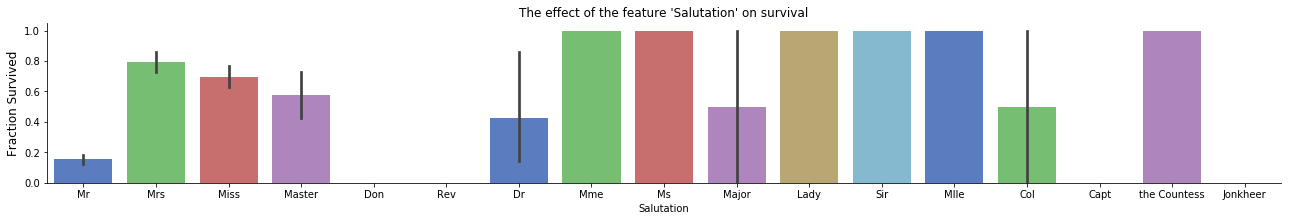

In [191]:
fig = sns.factorplot(x="Salutation", y="Survived", data=train,
                   size=3, aspect=6, kind="bar", palette="muted")
plt.title("The effect of the feature 'Salutation' on survival")
plt.ylabel("Fraction Survived", FontSize=12)
plt.show() 

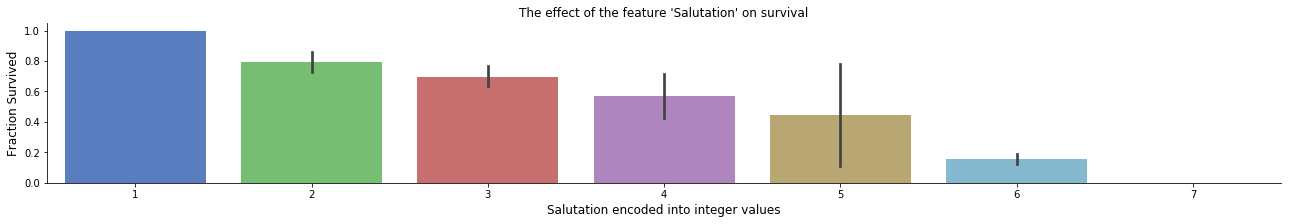

In [192]:
# lets encode the Salutation into 7 numeric values
dict_sal = dict({'Mr':6, 'Mrs':2, 'Miss':3, 'Master':4, 'Don':7, 'Rev':7, 'Dr':5, 'Mme':1, 'Ms':1, 'Major':4, 'Lady':1,\
 'Sir':1, 'Mlle':1,'Col':5, 'Capt':7, 'the Countess':1, 'Jonkheer':7})

train['Salutation'] = train['Salutation'].map(dict_sal).astype(int)

fig = sns.factorplot(x="Salutation", y="Survived", data=train,
                   size=3, aspect=6, kind="bar", palette="muted")
plt.title("The effect of the feature 'Salutation' on survival")
plt.ylabel("Fraction Survived", FontSize=12)
plt.xlabel("Salutation encoded into integer values", FontSize=12)
plt.show() 

#### We could also probably divide fares into 2 classes

In [193]:
train.loc[train['Fare'].between(0, 30, inclusive=True), 'Fare'] = 0
train.loc[train['Fare'].between(30.0001, 513, inclusive=True), 'Fare'] = 1
print(train.drop(['Name'], axis=1).head(3).to_string())

   PassengerId  Survived  Pclass     Sex  Age  SibSp  Parch            Ticket  Fare Cabin Embarked  Salutation
0            1         0       3    male   22      1      0         A/5 21171     0   NaN        S           6
1            2         1       1  female   38      1      0          PC 17599     1   C85        C           2
2            3         1       3  female   26      0      0  STON/O2. 3101282     0   NaN        S           3


### If we introduce the engineered features into Naive Bayes classifier would the prediction accuracy change? 